In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples2.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.A.22.R.A.36.R.G.48.,-_-_-,33.73_39.19_14.5,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
1,1b23.cif1_R,120,R.A.22.R.G.27.R.G.48.,-_-_-,23.6_22.89_14.5,0,0,1,0,1,...,0,0,0,0,0,0,0,5,0,0
2,1b23.cif1_R,0,R.G.19.R.G.57.R.C.69.,-_-_-,6.31_36.36_36.59,0,0,1,0,0,...,1,0,0,0,1,0,0,4,1,0
3,1b23.cif1_R,0,R.H2U.20.R.U.43.R.5MU.54.,-_-_-,24.47_37.47_24.2,0,0,1,0,0,...,1,0,0,0,1,0,0,7,1,0
4,1b23.cif1_R,0,R.C.44.R.G.52.R.C.62.,-_cWW_-,29.87_10.48_32.96,0,1,0,1,0,...,0,0,0,0,0,0,0,7,1,0


In [4]:
triplexes.shape

(34510, 477)

In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1318, '3j79.cif1_A': 966, '3j7p.cif1_S2': 764, '6ha1.cif1_a': 644, '6az1.cif1_1': 585, '3j7a.cif1_A': 483, '5xyi.cif1_2': 429, '6d9j.cif1_2': 383, '1u6b.cif1_B': 78, '5fdv.cif1_1B': 67, '4wf9.cif1_Y': 62, '4gxy.cif1_A': 58, '6ek0.cif1_L7': 53, '5xxb.cif1_3': 47, '5xym.cif1_B': 44, '6ha1.cif1_B': 41, '4qk8.cif1_A': 37, '3f2x.cif1_X': 34, '4rdx.cif1_C': 33, '2der.cif1_D': 32, '4mgn.cif1_A': 31, '5lys.cif1_B': 30, '3dil.cif1_A': 28, '4qlm.cif1_A': 28, '5d8h.cif1_A': 26, '5hr7.cif1_D': 26, '1j1u.cif1_B': 25, '5aj0.cif1_Bv': 25, '5mrc.cif1_bb': 25, '3eph.cif1_E': 24, '4mgn.cif1_B': 24, '6gaw.cif1_BB': 23, '5u3g.cif1_B': 22, '5jup.cif1_EC': 21, '6az3.cif1_7': 21, '3npq.cif1_A': 20, '4lvw.cif1_A': 20, '4y1m.cif1_B': 20, '3tup.cif1_T': 19, '5e81.cif1_1K': 19, '6ek0.cif1_L8': 19, '3la5.cif1_A': 18, '4gcw.cif1_B': 18, '5ud5.cif1_C': 18, '1i6u.cif1_C': 17, '1mms.cif1_C': 16, '4lx6.cif1_A': 15, '4v9k.cif1_AW': 15, '4wsm.cif1_3L': 12, '1s03.cif1_B': 11, '3e5c.cif

111 5.C.1594.5.C.1598.5.A.1599. -_cWH_cSH 9.64_5.94_9.29 PROBA:  0.48904569736712494
111 5.U.1596.5.U.2359.5.A.3861. -_tWH_cWS 15.05_9.95_5.85 PROBA:  0.2989641206589583
111 5.A.1613.5.U.3637.5.A.3651. cHW_-_cWS 8.59_11.89_9.5 PROBA:  0.46776485408849244
111 5.G.1641.5.G.3918.5.U.4383. cSS_cWW_- 4.73_10.21_13.58 PROBA:  0.4585033226221173
111 5.C.1662.5.G.2287.5.G.2320. cWW_t.W_cSS 10.71_13.45_5.31 PROBA:  0.47470429105424145
111 5.G.1810.5.C.1827.5.C.1828. cWW_-_cWW 13.43_5.73_10.59 PROBA:  0.1637044619113693
111 5.A.1858.5.C.1859.5.C.1875. -_cWW_cWW 5.66_10.42_12.38 PROBA:  0.29404120753077906
111 5.A.1867.5.U.4403.5.G.4440. cSS_cWW_tWW 5.25_10.36_12.18 PROBA:  0.3636527125125923
111 5.C.1884.5.G.1895.5.A.1907. cWW_cSW_- 9.98_5.42_12.62 PROBA:  0.340039563438518
111 5.G.1885.5.C.1894.5.A.1907. cWW_-_tSW 10.23_9.35_9.01 PROBA:  0.35771133630212865
111 5.U.1947.5.A.4692.5.U.4697. cWW_tHW_- 10.86_10.8_13.85 PROBA:  0.15741500712183448
111 5.G.1972.5.C.1993.5.C.1994. cWW_-_cWW 13.46_5.42

111 EC.U.6787.EC.G.6808.EC.G.6809. c.W_cSH_cWH 13.11_7.44_11.33 PROBA:  0.49079269494598643
111 EC.A.6790.EC.C.6850.EC.G.6878. -_cWW_tSS 6.86_10.8_5.92 PROBA:  0.190633871571162
CONFUSION MATRIX By chain:  5jup.cif1_EC
[[18  0]
 [ 2  1]]

CONFUSION MATRIX By chain:  4pqv.cif1_A
[[3]]

0 B.A.17.B.A.18.B.C.26. -_-_- 5.45_24.67_25.83 PROBA:  0.548632051107632
112 B.G.31.B.C.36.B.C.47. -_-_cWW 16.41_7.88_10.94 PROBA:  0.5305697822509796
CONFUSION MATRIX By chain:  6ha1.cif1_B
[[32  2]
 [ 0  7]]

110 B.A.27.B.G.34.B.C.50. -_cWW_- 26.24_11.33_25.19 PROBA:  0.5427325440589482
CONFUSION MATRIX By chain:  5xym.cif1_B
[[36  1]
 [ 0  7]]

112 A.A.43.A.C.63.A.G.151. -_cWW_- 10.62_10.53_10.25 PROBA:  0.5277950146041973
111 A.G.11.A.G.40.A.C.161. cWH_cWW_... 11.52_10.56_14.29 PROBA:  0.4965441097866277
111 A.G.11.A.G.41.A.C.160. -_cWW_tHW 12.78_11.13_12.34 PROBA:  0.16715776994455125
111 A.A.43.A.G.64.A.C.72. cWS_cWW_- 5.24_10.57_12.48 PROBA:  0.32666657340144456
111 A.G.55.A.U.77.A.A.150. -_tWH_cSW

111 A.A.11.A.A.1244.A.A.1402. cWW_tSW_cWS 12.05_8.99_5.59 PROBA:  0.04265956444242915
111 A.U.12.A.A.1243.A.G.1401. cWW_-_cSS 10.44_12.05_5.52 PROBA:  0.4799365902291129
111 A.U.32.A.A.474.A.A.601. tWH_cWS_- 9.64_9.18_8.43 PROBA:  0.24971936460534935
111 A.A.47.A.U.100.A.A.391. cHS_cWW_- 7.7_10.55_12.08 PROBA:  0.4498327694489073
111 A.A.61.A.C.270.A.G.292. cWS_cWW_tW. 6.17_10.96_12.89 PROBA:  0.40486571168382873
111 A.A.110.A.U.312.A.A.857. cWW_tSH_- 10.32_10.12_9.25 PROBA:  0.25966088418976613
111 A.U.115.A.G.307.A.U.340. cWW_tSW_- 10.2_9.28_9.18 PROBA:  0.38540276730842726
111 A.U.168.A.C.268.A.G.294. -_cWW_tHW 5.19_10.54_11.05 PROBA:  0.36302367231914645
111 A.G.369.A.C.387.A.A.805. cWW_cSW_c.H 10.68_8.73_12.99 PROBA:  0.33930761419418504
111 A.G.370.A.G.383.A.A.806. tHS_-_tSW 10.31_18.67_9.66 PROBA:  0.3175600292226406
111 A.A.418.A.U.419.A.A.427. -_cWH_cWH 6.58_8.16_11.52 PROBA:  0.31312064956889196
111 A.A.1047.A.G.2066.A.C.2079. tSS_cWW_- 7.77_10.63_6.13 PROBA:  0.4905394355267

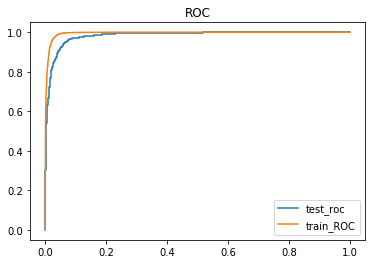

Probability density for train


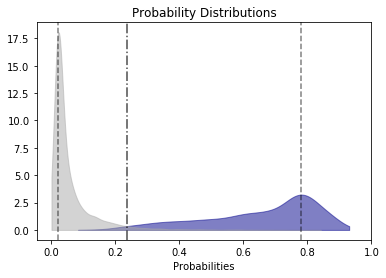

Probability density for test


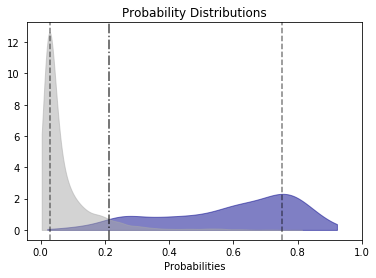


[[5816   70]
 [ 309  707]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   70  5886
1           309  707  1016
All        6125  777  6902


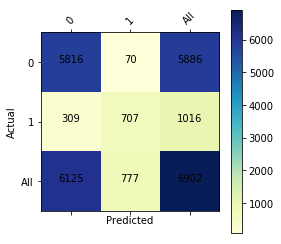


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.91      0.70      0.79      1016

avg / total       0.94      0.95      0.94      6902

ACCURACY =  0.945088380179658
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 992, '5mrc.cif1_A': 832, '6d9j.cif1_5': 727, '5ool.cif1_A': 572, '3jam.cif1_2': 506, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 340, '4p95.cif1_A': 92, '1u9s.cif1_A': 73, '4v9f.cif1_9': 63, '4ioa.cif1_Y': 59, '3j79.cif1_B': 55, '4r4v.cif1_A': 48, '4plx.cif1_A': 46, '5fjc.cif1_A': 42, '6d90.cif1_4': 38, '4oqu.cif1_A': 36, '3u4m.cif1_B': 33, '6d9j.cif1_7': 33, '4yco.cif1_D': 31, '4wj4.cif1_B': 29, '5e6m.cif1_C': 29, '2du3.cif1_D': 27, '2gdi.cif1_X': 26, '4p5j.cif1_A': 26, '1il2.cif1_C': 25, '1n78.cif1_C': 25, '3q3z.cif1_V': 25, '1u0b.cif1_A': 24, '2csx.cif1_C': 24, '4qei.cif1_C': 24, '4lck.cif1_B': 22, '3j7q.cif1_8': 21, '5hr6.cif1_C': 21, '2d6f.cif1_F': 20, '4fen.cif1_B':

[[26  2]
 [ 5  0]]

123 C.A.9.C.C.11.C.G.22. -_-_- 10.24_16.34_9.78 PROBA:  0.5272792592130644
CONFUSION MATRIX By chain:  2csx.cif1_C
[[19  1]
 [ 0  4]]

112 C.C.11.C.G.23.C.C.47. cWW_-_- 10.63_16.06_15.94 PROBA:  0.5307701881663816
111 C.G.14.C.C.19.C.C.47. tSW_tWW_tWW 9.0_10.58_10.38 PROBA:  0.22657169885441394
CONFUSION MATRIX By chain:  5hr6.cif1_C
[[16  1]
 [ 1  3]]

111 A.G.23.A.G.52.A.U.72. tSS_-_tHS 7.95_12.98_6.61 PROBA:  0.165233859519331
CONFUSION MATRIX By chain:  5kpy.cif1_A
[[3 0]
 [1 0]]

120 C.G.18.C.A.21.C.U.22. -_-_- 14.15_7.03_19.06 PROBA:  0.5425546757661917
111 C.U.8.C.A.14.C.A.21. tWH_cWS_tSW 9.71_9.11_8.3 PROBA:  0.4520041691595298
111 C.U.13.C.U.22.C.A.46. cWW_tHW_- 8.86_12.24_11.75 PROBA:  0.2378853843645797
CONFUSION MATRIX By chain:  4qei.cif1_C
[[19  1]
 [ 2  2]]

CONFUSION MATRIX By chain:  4rum.cif1_A
[[1 0]
 [0 1]]

112 2.C.297.2.G.362.2.C.380. -_cWW_- 24.82_10.76_20.34 PROBA:  0.5984532669833493
111 2.G.10.2.U.1143.2.A.1631. cWW_cWW_- 9.91_11.22_5.77 PR

 [0 2]]

110 C.U.37.C.A.103.C.OMC.105. -_-_cWW 8.42_8.96_7.99 PROBA:  0.6239311673166966
CONFUSION MATRIX By chain:  5t5h.cif1_C
[[15  1]
 [ 0  3]]

111 A.G.10.A.U.11.A.C.49. cSH_-_cWW 6.41_11.89_10.46 PROBA:  0.36704647801170526
111 A.C.61.A.G.68.A.C.77. -_cWW_cSH 13.87_10.57_7.47 PROBA:  0.4338204880918083
CONFUSION MATRIX By chain:  4p5j.cif1_A
[[22  0]
 [ 2  2]]

CONFUSION MATRIX By chain:  5czz.cif1_B
[[2 0]
 [0 1]]

112 A.G.2543.A.G.2544.A.A.2565. -_tSS_- 5.27_8.29_12.8 PROBA:  0.5930048598019589
CONFUSION MATRIX By chain:  3moj.cif1_A
[[7 1]
 [0 2]]

111 X.U.20.X.U.49.X.A.76. -_cWS_cWW 11.11_6.03_10.18 PROBA:  0.4689962795802313
CONFUSION MATRIX By chain:  4xnr.cif1_X
[[14  0]
 [ 1  2]]

112 C.G.10.C.A.21.C.U.25. -_-_cWW 18.46_17.89_10.33 PROBA:  0.5192970243954461
111 C.U.8.C.A.14.C.A.21. tWH_cWS_tSW 9.67_9.24_8.25 PROBA:  0.45733750249286315
111 C.U.13.C.U.22.C.A.46. cWW_tHW_- 8.71_12.04_11.67 PROBA:  0.2378853843645797
CONFUSION MATRIX By chain:  5e6m.cif1_C
[[23  1]
 [ 2  3]

110 O.U.77.O.C.94.O.A.98. -_-_cSW 13.55_18.2_7.97 PROBA:  0.5818671190440896
123 O.U.77.O.C.96.O.C.97. -_-_- 8.02_5.58_7.89 PROBA:  0.5445527331868067
CONFUSION MATRIX By chain:  1kog.cif1_O
[[8 2]
 [0 3]]

CONFUSION MATRIX By chain:  6cmn.cif1_D
[[1 0]
 [0 1]]

111 B.G.19.B.U.20.B.C.56. cSW_-_cWW 6.68_12.85_10.73 PROBA:  0.4781858731993659
123 B.U.12.B.C.25.B.G.46. -_-_- 7.87_17.12_16.32 PROBA:  0.5082833554774098
CONFUSION MATRIX By chain:  4wj4.cif1_B
[[23  1]
 [ 1  4]]

111 B.G.15.B.C.20.AB.C.48. tSW_tWW_tWW 8.87_10.58_10.23 PROBA:  0.2103730464701351
CONFUSION MATRIX By chain:  1h3e.cif1_B
[[7 0]
 [1 1]]

112 B.U.30.B.A.35.B.C.39. cWW_-_- 10.69_7.89_10.7 PROBA:  0.5813507489247849
112 B.U.30.B.C.32.B.A.35. cWH_-_cWW 9.08_9.38_10.69 PROBA:  0.5247217028883598
112 B.U.30.B.C.32.B.G.36. cWH_cWW_- 9.08_10.74_13.05 PROBA:  0.5769939885241725
110 B.U.30.B.U.33.B.A.40. -_-_- 11.13_11.39_8.96 PROBA:  0.60303338108404
123 B.U.30.B.G.36.B.C.39. -_-_- 13.05_5.71_10.7 PROBA:  0.50470198672807

[[78  2]
 [ 9  3]]

123 QV.U.7.QV.G.45.QV.G.46. -_-_- 13.85_7.34_7.3 PROBA:  0.6257001325441973
CONFUSION MATRIX By chain:  4tue.cif1_QV
[[14  1]
 [ 0  3]]

112 9.U.28.9.A.54.9.G.58. cWW_-_- 10.51_13.35_6.79 PROBA:  0.7387512881683428
112 9.G.32.9.G.50.9.A.52. -_-_- 7.42_10.93_11.53 PROBA:  0.6040696138022621
CONFUSION MATRIX By chain:  4v9f.cif1_9
[[51  2]
 [ 0 10]]

112 X.G.19.X.C.22.X.G.37. -_cWW_- 14.67_10.45_20.95 PROBA:  0.6213873706616578
111 X.G.21.X.C.38.X.U.71. cWW_-_cSS 10.85_8.79_6.87 PROBA:  0.24148490296044473
CONFUSION MATRIX By chain:  2gdi.cif1_X
[[21  1]
 [ 1  3]]

AUC_TRAIN =  0.9950925256116633

AUC =  0.9838267147167911


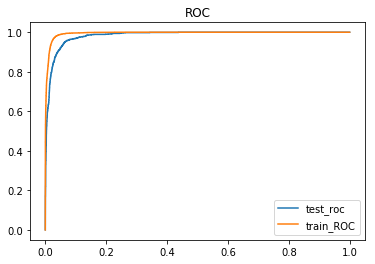

Probability density for train


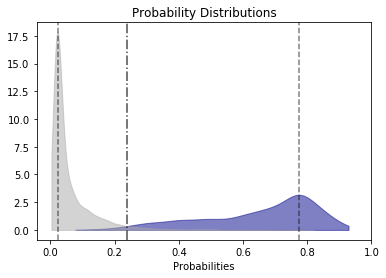

Probability density for test


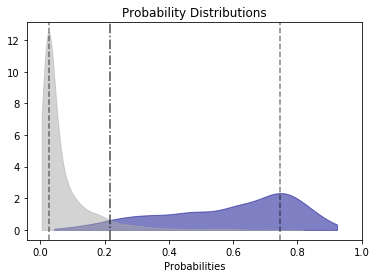


[[5816   72]
 [ 337  677]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   72  5888
1           337  677  1014
All        6153  749  6902


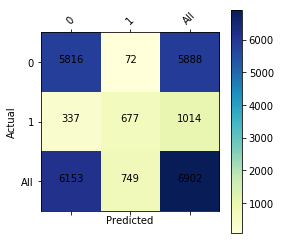


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.90      0.67      0.77      1014

avg / total       0.94      0.94      0.94      6902

ACCURACY =  0.9407418139669661
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1011, '5xxb.cif1_1': 844, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 550, '5xxu.cif1_2': 474, '5ngm.cif1_Aa': 461, '5t5h.cif1_B': 282, '6gaz.cif1_AA': 277, '3j7o.cif1_7': 58, '5xy3.cif1_3': 54, '3mxh.cif1_R': 47, '4kqy.cif1_A': 45, '6eri.cif1_Ax': 42, '2qwy.cif1_C': 37, '2r8s.cif1_R': 34, '3v7e.cif1_C': 33, '5t83.cif1_A': 33, '5ccb.cif1_N': 31, '1mfq.cif1_A': 30, '4yye.cif1_C': 29, '6d9j.cif1_8': 27, '4v8n.cif1_CV': 26, '6az3.cif1_4': 26, '3al0.cif1_E': 25, '3d2v.cif1_A': 25, '6eri.cif1_AB': 25, '3amu.cif1_B': 24, '3kfu.cif1_L': 24, '5nwq.cif1_A': 24, '5ool.cif1_B': 22, '5ktj.cif1_A': 21, '5oql.cif1_2': 21, '4v90.cif1_AV': 20, '5xxb.cif1_4': 20, '1y26.cif1_X': 19, '3g

0 A.G.28.A.A.31.A.A.32. -_-_- 8.44_8.59_15.82 PROBA:  0.8070371255407504
100 A.U.15.A.C.22.A.A.29. -_-_- 15.91_26.26_22.09 PROBA:  0.5192428936163115
111 A.G.13.A.C.26.A.U.59. cWW_-_cSS 10.74_8.76_6.68 PROBA:  0.2454966181754768
CONFUSION MATRIX By chain:  3d2v.cif1_A
[[19  2]
 [ 1  3]]

111 CV.C.11.CV.C.27.CV.G.47. cWW_-_... 7.48_14.36_11.9 PROBA:  0.29031953752840367
CONFUSION MATRIX By chain:  4v8n.cif1_CV
[[22  0]
 [ 1  3]]

0 A.A.22.A.A.27.A.C.30. -_-_- 12.86_11.07_7.63 PROBA:  0.6516330069517461
112 A.C.15.A.A.35.A.G.37. -_-_cWW 13.65_9.34_10.6 PROBA:  0.7564056728183979
112 A.A.12.A.A.13.A.U.38. -_-_cWW 5.3_10.13_10.9 PROBA:  0.7464328385989032
123 A.A.14.A.C.15.A.U.16. -_-_- 5.17_5.81_10.52 PROBA:  0.6048759160218253
CONFUSION MATRIX By chain:  1s03.cif1_A
[[9 4]
 [0 3]]

112 AB.G.42.AB.C.83.AB.A.86. -_-_- 12.41_11.03_8.81 PROBA:  0.6010009821049946
112 AB.C.83.AB.C.84.AB.A.86. -_-_- 6.82_10.82_11.03 PROBA:  0.6888407692192886
CONFUSION MATRIX By chain:  6eri.cif1_AB
[[19  2]
 

112 4.C.45.4.G.46.4.A.59. -_-_- 5.08_9.14_12.66 PROBA:  0.6056508660798442
CONFUSION MATRIX By chain:  5xxb.cif1_4
[[16  1]
 [ 0  3]]

112 Ax.G.24.Ax.C.27.Ax.A.58. tSW_-_- 9.28_18.53_14.93 PROBA:  0.8138349052693735
112 Ax.G.24.Ax.C.28.Ax.A.59. -_-_cWW 10.09_10.18_14.38 PROBA:  0.7529994716481615
110 Ax.C.30.Ax.G.53.Ax.G.54. -_-_cWW 12.3_5.8_10.7 PROBA:  0.6489009366314895
123 Ax.A.29.Ax.C.30.Ax.A.58. -_-_- 5.18_7.23_9.22 PROBA:  0.6671204222751235
CONFUSION MATRIX By chain:  6eri.cif1_Ax
[[31  4]
 [ 0  7]]

112 AA.G.200.AA.A.208.AA.A.444. -_-_tSW 36.16_33.41_11.88 PROBA:  0.6459597843302707
111 AA.G.53.AA.C.114.AA.A.124. cWW_cSW_t.W 11.08_5.55_12.65 PROBA:  0.48021226142633283
111 AA.G.54.AA.C.113.AA.A.125. cWW_-_tSS 10.83_5.51_8.22 PROBA:  0.4218748966813626
111 AA.G.172.AA.C.194.AA.A.1386. cWW_-_cSW 10.88_12.51_6.17 PROBA:  0.4269964191265136
111 AA.A.208.AA.C.419.AA.G.432. -_cWW_cSS 8.13_10.79_5.89 PROBA:  0.49224087802919736
111 AA.A.213.AA.C.428.AA.G.2424. -_cWW_cHS 13.39_10.84_8

112 C.C.11.C.G.22.C.G.46. -_tHW_- 16.9_11.04_14.72 PROBA:  0.5433143018667884
CONFUSION MATRIX By chain:  4yye.cif1_C
[[23  1]
 [ 0  5]]

111 C.A.12.C.G.43.C.C.91. cSS_cWW_tWS 5.34_10.44_8.57 PROBA:  0.2467418640113336
111 C.A.24.C.U.96.C.A.117. -_cWW_tWS 10.93_10.29_9.25 PROBA:  0.21703550322959322
123 C.A.93.C.A.94.C.U.96. -_-_- 5.29_11.96_14.32 PROBA:  0.5785485411982633
123 C.G.22.C.G.23.C.A.24. -_-_- 5.51_9.32_12.07 PROBA:  0.5488125720433569
CONFUSION MATRIX By chain:  3v7e.cif1_C
[[26  2]
 [ 2  3]]

120 Q.G.67.Q.A.80.Q.A.87. -_-_- 18.67_14.49_12.63 PROBA:  0.5679698324478717
111 Q.C.29.Q.G.45.Q.A.98. cWW_tSW_- 10.78_10.61_9.52 PROBA:  0.1893979531966472
111 Q.U.70.Q.A.80.Q.G.135. cWW_-_tSW 11.01_10.33_9.69 PROBA:  0.345317717992303
CONFUSION MATRIX By chain:  3g9c.cif1_Q
[[15  1]
 [ 2  1]]

111 B.A.21.B.U.48.B.U.75. tW._cWS_cWW 10.92_6.06_10.56 PROBA:  0.2595864981480982
CONFUSION MATRIX By chain:  5swd.cif1_B
[[2 0]
 [1 0]]

AUC_TRAIN =  0.995014998188377

AUC =  0.987033434096

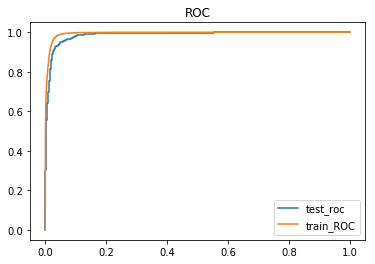

Probability density for train


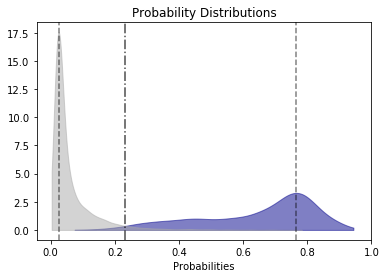

Probability density for test


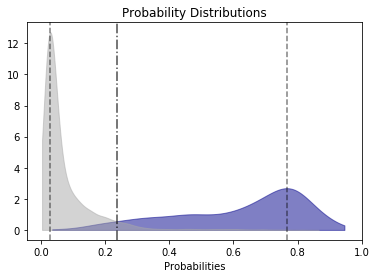


[[5821   67]
 [ 283  731]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5821   67  5888
1           283  731  1014
All        6104  798  6902


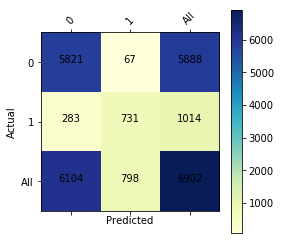


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.92      0.72      0.81      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.949290060851927
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1099, '6ha1.cif1_A': 1023, '5tbw.cif1_1': 932, '4v88.cif1_A6': 640, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 158, '1nbs.cif1_B': 65, '3igi.cif1_A': 62, '5j7l.cif1_DB': 56, '6az3.cif1_8': 53, '5ml7.cif1_B': 46, '3ivk.cif1_M': 43, '3hhn.cif1_E': 38, '1yfg.cif1_A': 37, '4uyk.cif1_R': 34, '1h4s.cif1_T': 33, '4lck.cif1_F': 32, '4aob.cif1_A': 30, '4y1j.cif1_A': 29, '3wqy.cif1_C': 28, '6cb3.cif1_B': 27, '3wfs.cif1_A': 26, '1fir.cif1_A': 25, '1qtq.cif1_B': 25, '3ski.cif1_A': 25, '6ck5.cif1_A': 25, '1gax.cif1_D': 24, '3j79.cif1_C': 24, '5axm.cif1_P': 23, '3d0u.cif1_A': 21, '6az3.cif1_5': 21, '1ser.cif1_T': 20, '3oxe.cif1_A': 20, '3w3s.ci

111 A.C.14.A.G.30.A.A.40. cWW_tSS_- 10.83_8.36_5.58 PROBA:  0.4894698407636999
111 A.C.15.A.G.19.A.A.39. cWW_t.W_cSW 10.7_12.97_5.54 PROBA:  0.2348742735054685
CONFUSION MATRIX By chain:  4oji.cif1_A
[[8 0]
 [2 0]]

112 C.A.21.C.A.23.C.U.75. -_-_cWW 10.96_16.87_10.52 PROBA:  0.6210354542906651
CONFUSION MATRIX By chain:  3rkf.cif1_C
[[12  1]
 [ 0  3]]

112 A.A.22.A.U.31.A.A.61. -_-_- 7.43_7.85_11.22 PROBA:  0.6777780700141007
111 A.A.12.A.G.43.A.C.59. cSS_cWW_- 5.59_10.65_8.61 PROBA:  0.3641716501656404
CONFUSION MATRIX By chain:  4aob.cif1_A
[[24  1]
 [ 1  4]]

112 T.A.14.T.G.15.T.H2U.20.A -_tSW_- 5.19_7.61_10.72 PROBA:  0.5921519956412087
111 T.U.8.T.A.14.T.A.21. tWH_cWS_- 9.72_9.87_8.87 PROBA:  0.4931559919282893
111 T.G.15.T.H2U.20.AT.C.48. tSW_t.W_tWW 7.61_10.45_10.71 PROBA:  0.1445204647922918
110 T.G.15.T.C.20.T.H2U.20.A -_-_tSW 11.03_7.3_7.61 PROBA:  0.7046891966998237
CONFUSION MATRIX By chain:  1ser.cif1_T
[[15  2]
 [ 2  1]]

CONFUSION MATRIX By chain:  1kuq.cif1_B
[[4 0]
 [0

111 A.C.2076.A.G.2650.A.A.2848. cWW_-_cSW 10.66_11.8_9.66 PROBA:  0.4791247348597192
111 A.A.2143.A.U.2196.A.A.2200. -_tWH_tWW 6.12_10.86_14.26 PROBA:  0.22420212799998496
111 A.U.2147.A.C.2172.A.G.2177. -_cWW_cHS 12.4_11.27_7.25 PROBA:  0.309772149082482
111 A.C.2277.A.G.2284.A.C.2304. -_cWW_cWH 13.57_10.53_8.79 PROBA:  0.07702558182565053
111 A.G.2748.A.U.2749.A.A.2898. cSH_cWH_- 6.79_8.66_14.0 PROBA:  0.2265788104377138
110 A.G.457.A.C.464.A.A.575. cWW_-_- 10.88_113.81_103.93 PROBA:  0.5079534090834432
CONFUSION MATRIX By chain:  6ha1.cif1_A
[[873   3]
 [ 41 106]]

CONFUSION MATRIX By chain:  1fir.cif1_A
[[21  0]
 [ 0  4]]

112 A.G.998.A.G.1068.A.C.1077. -_cWW_- 89.33_10.77_85.69 PROBA:  0.5469006023008444
111 A.U.41.A.A.397.A.A.527. tWW_cHS_- 11.32_7.76_8.87 PROBA:  0.4716178673275512
111 A.A.55.A.U.110.A.A.313. cHS_cWW_- 7.65_10.64_12.5 PROBA:  0.4434304608951472
111 A.A.69.A.C.213.A.G.218. -_cWW_tWS 6.54_10.61_8.77 PROBA:  0.31932860862179974
111 A.G.108.A.A.315.A.U.328. cWW_cHH_

120 BA.G.1152.BA.A.1465.BA.G.1466. -_-_- 74.9_4.51_73.53 PROBA:  0.5495824876104237
111 BA.A.51.BA.C.246.BA.G.346. -_cWW_tSS 6.2_10.59_7.9 PROBA:  0.41322125922522757
111 BA.A.54.BA.U.61.BA.G.84. cWW_tSW_- 10.46_9.48_12.01 PROBA:  0.4183531808095744
111 BA.A.55.BA.U.60.BA.G.84. -_tHW_cSW 11.71_11.17_7.7 PROBA:  0.41787324080207533
111 BA.C.58.BA.G.82.BA.A.1255. cWW_tSH_- 10.6_6.73_11.89 PROBA:  0.36081478038209064
111 BA.U.109.BA.A.199.BA.U.636. -_cWW_cWS 10.69_10.78_6.29 PROBA:  0.43541017377514524
111 BA.A.124.BA.C.251.BA.G.341. cSS_cWW_- 5.86_10.82_13.38 PROBA:  0.2845026888491677
111 BA.A.150.BA.U.198.BA.A.637. cSS_cWW_- 5.62_10.79_13.25 PROBA:  0.34872485531745817
111 BA.A.164.BA.A.1014.BA.G.1030. -_cWW_cW. 9.56_12.57_11.32 PROBA:  0.2897830259574787
111 BA.A.164.BA.C.1015.BA.G.1029. cWS_cWW_- 7.97_10.82_14.33 PROBA:  0.40658587838939936
111 BA.C.241.BA.U.354.BA.A.1055. cWW_cSW_- 11.36_8.71_14.7 PROBA:  0.335554613573552
111 BA.G.276.BA.C.826.BA.U.842. cWW_tHW_- 9.99_9.3_10.92 PRO

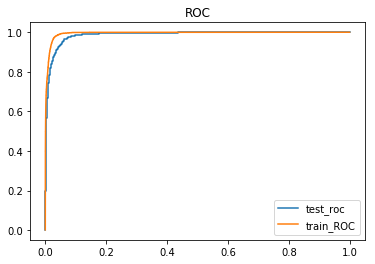

Probability density for train


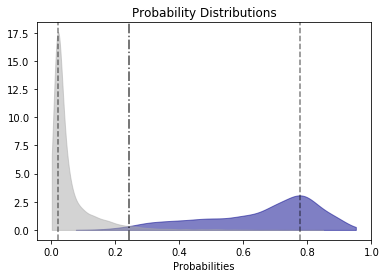

Probability density for test


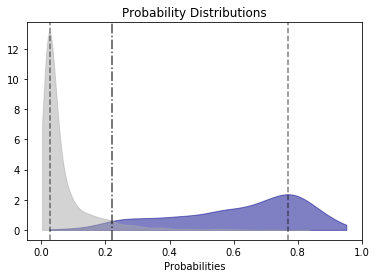


[[5826   60]
 [ 281  735]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5826   60  5886
1           281  735  1016
All        6107  795  6902


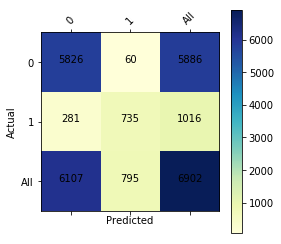


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.92      0.72      0.81      1016

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9505940307157346
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1042, '5o60.cif1_A': 1039, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 649, '4lfb.cif1_A': 587, '6eri.cif1_BA': 541, '5an9.cif1_N': 413, '6az3.cif1_2': 286, '5t2a.cif1_B': 250, '2a64.cif1_A': 61, '5t5h.cif1_D': 55, '3pdr.cif1_X': 51, '5tbw.cif1_AS': 46, '4yaz.cif1_R': 43, '4ycp.cif1_B': 41, '1c0a.cif1_B': 36, '3ndb.cif1_M': 33, '5wt1.cif1_C': 33, '4pr6.cif1_B': 31, '4prf.cif1_B': 31, '3iwn.cif1_A': 29, '4qk9.cif1_A': 28, '2azx.cif1_D': 26, '2qus.cif1_A': 26, '5tbw.cif1_4': 26, '3skl.cif1_B': 25, '5l4o.cif1_A': 25, '5mgp.cif1_x': 25, '1evv.cif1_A': 24, '1qf6.cif1_B': 24, '5o2r.cif1_x': 23, '4rzd.cif1_A': 21, '6gaz.cif1_AV': 21, '5e81.cif1_2K': 20, '5wwt.cif1_C': 20, '6cfj.cif1_1x': 20, '1b23

111 B.G.619.B.H2U.620.B.C.656. cSH_-_cWW 6.26_11.29_10.62 PROBA:  0.3406772972779672
123 B.G.610.B.A.624.B.G7M.646. -_-_- 13.53_14.16_9.95 PROBA:  0.5980802637353907
CONFUSION MATRIX By chain:  1c0a.cif1_B
[[29  1]
 [ 1  5]]

112 2.OMU.667.2.A.1037.2.A2M.1186. cWW_-_- 10.59_50.59_41.44 PROBA:  0.565947524713292
111 2.G.396.2.U.432.2.A.559. cWW_cSS_- 10.37_4.71_12.2 PROBA:  0.2867105697203954
111 2.A2M.527.2.A.1397.2.U.1413. -_cWW_cSS 11.2_10.17_4.46 PROBA:  0.41838382806188557
111 2.U.544.2.OMU.1360.2.C.1364. -_tWH_c.W 5.26_10.84_12.16 PROBA:  0.4981402883034704
111 2.A.555.2.G.1400.2.C.1409. cWS_cWW_- 6.06_10.7_12.89 PROBA:  0.46934188571031876
111 2.A.619.2.G.1263.2.U.1304. cSS_cWW_- 5.02_10.92_13.58 PROBA:  0.2982939296782154
111 2.G.780.2.U.811.2.U.1011. cWW_-_cSH 11.06_11.45_8.94 PROBA:  0.1332606707424078
111 2.U.1045.2.G.1051.2.C.1072. -_cWW_cSH 11.64_10.29_7.59 PROBA:  0.3166206136838768
111 2.C.1058.2.G.1076.2.A.1124. cWW_cSS_- 10.61_5.96_8.24 PROBA:  0.48712198827360687
110 2

123 C.C.13.C.A.14.C.A.23. -_-_- 5.82_7.17_8.58 PROBA:  0.5248138988308935
CONFUSION MATRIX By chain:  5wwt.cif1_C
[[16  1]
 [ 0  3]]

CONFUSION MATRIX By chain:  5xtm.cif1_D
[[3 0]
 [0 1]]

111 B.A.7.B.U.26.B.A.27. cWW_cSH_- 10.64_5.96_12.64 PROBA:  0.30913561892431973
111 B.C.9.B.G.24.B.A.31. cWW_cSW_- 10.88_9.88_11.02 PROBA:  0.3333606810393853
111 B.A.10.B.U.23.B.A.31. cWW_-_tSW 10.7_13.33_8.87 PROBA:  0.32726813011004097
CONFUSION MATRIX By chain:  4rmo.cif1_B
[[14  0]
 [ 3  0]]

100 x.G.10.x.C.24.x.G.27. -_-_- 17.18_14.34_7.79 PROBA:  0.5281060650124877
CONFUSION MATRIX By chain:  6ha1.cif1_x
[[2 1]
 [0 1]]

112 B.A.53.B.G.62.B.U.65. -_-_cWW 15.15_10.45_10.49 PROBA:  0.5726426715263097
111 B.A.53.B.U.65.B.A.86. cWW_cSW_- 10.49_9.54_11.31 PROBA:  0.4670026227337719
CONFUSION MATRIX By chain:  5x2g.cif1_B
[[9 1]
 [1 0]]

CONFUSION MATRIX By chain:  1un6.cif1_F
[[8 0]
 [0 2]]

111 AV.U.8.AV.A.14.AV.A.18. tWH_cWS_tSW 9.75_11.47_8.87 PROBA:  0.3979268731511126
CONFUSION MATRIX By chain

[[888   2]
 [ 35 114]]

123 C.A.134.C.A.140.C.G.149. -_-_- 22.78_17.72_26.99 PROBA:  0.5684703854501223
CONFUSION MATRIX By chain:  1hc8.cif1_C
[[12  1]
 [ 0  3]]

112 N.A.2561.N.C.3361.N.G.3366. -_cWW_- 40.89_10.77_32.63 PROBA:  0.6886044572147466
111 N.A.1263.N.G.2965.N.C.2979. cSS_cWW_tSS 5.75_10.57_8.01 PROBA:  0.39035453727611014
111 N.G.1363.N.C.1369.N.G.2951. cWW_-_cSW 10.75_8.83_11.53 PROBA:  0.4308930200981875
111 N.U.1365.N.U.3159.N.G.3196. -_cWW_t.W 9.65_10.61_12.15 PROBA:  0.35801449683130754
111 N.G.1382.N.A.1395.N.U.1567. cWS_-_tSW 11.13_9.84_8.75 PROBA:  0.21580750959609463
111 N.G.1385.N.C.1392.N.A.1432. cWW_cSW_- 10.74_8.6_13.08 PROBA:  0.421081831296859
111 N.G.1408.N.A.1415.N.C.1564. t.W_-_cWW 12.93_5.64_10.59 PROBA:  0.3443874720048252
111 N.A.1409.N.A.1416.N.U.1563. tSW_-_cWW 8.01_5.36_10.67 PROBA:  0.34551873903647945
111 N.C.1459.N.C.1519.N.G.3452. t.W_c.W_cWH 11.73_9.48_10.12 PROBA:  0.21143560205868547
111 N.G.1481.N.G.1501.N.C.1510. cWH_cWW_... 12.12_10.7_14.1

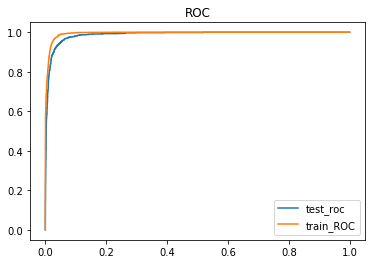

Probability density for train


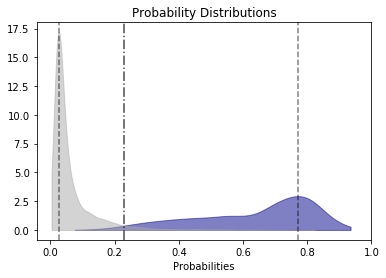

Probability density for test


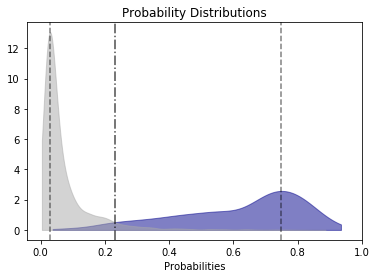


[[5829   59]
 [ 272  742]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5829   59  5888
1           272  742  1014
All        6101  801  6902


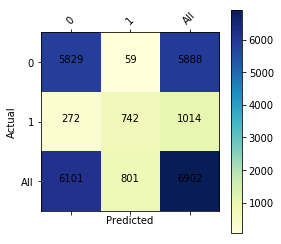


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5888
          1       0.93      0.73      0.82      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9520428861199652
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9953740006520312

AUC =  0.98508358720462


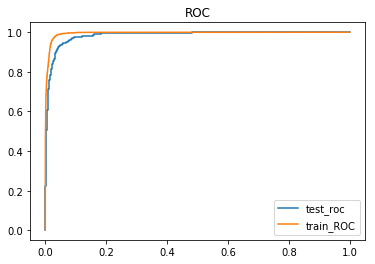

Probability density for train


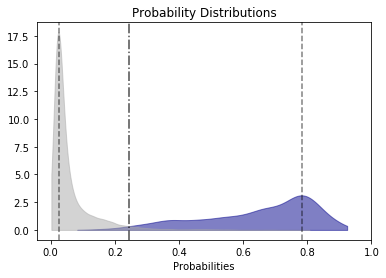

Probability density for test


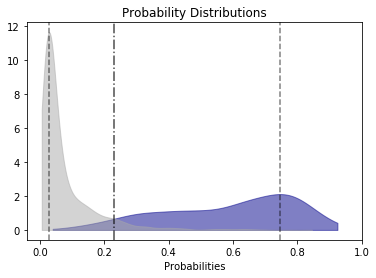


[[2914   28]
 [ 172  337]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2914   28  2942
1           172  337   509
All        3086  365  3451


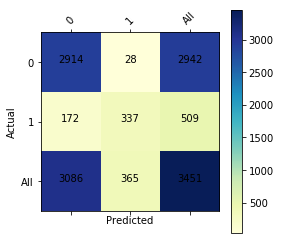

REPORT
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2942
          1       0.92      0.66      0.77       509

avg / total       0.94      0.94      0.94      3451

ACCURACY 0.9420457838307736
-----------------

AUC_TRAIN =  0.994915353576023

AUC =  0.9846110653287443


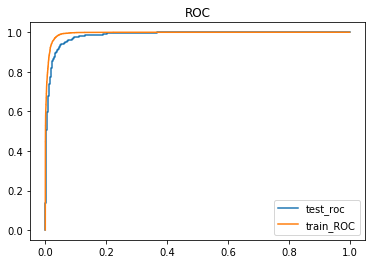

Probability density for train


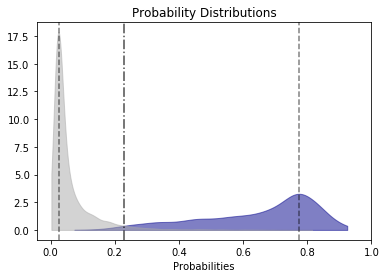

Probability density for test


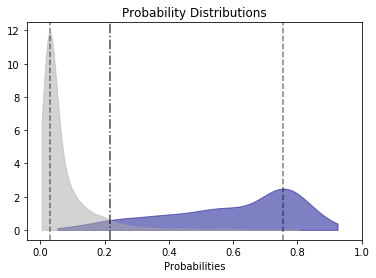


[[2913   34]
 [ 150  354]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2913   34  2947
1           150  354   504
All        3063  388  3451


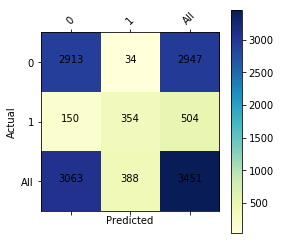

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2947
          1       0.91      0.70      0.79       504

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9466821211243118
-----------------

AUC_TRAIN =  0.9947186263212727

AUC =  0.9848540912454746


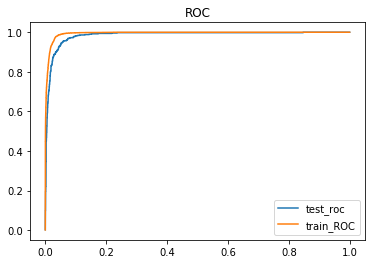

Probability density for train


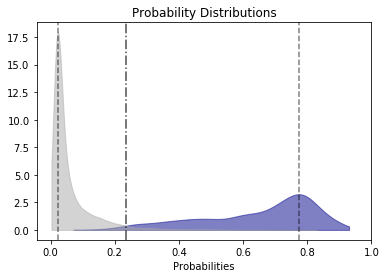

Probability density for test


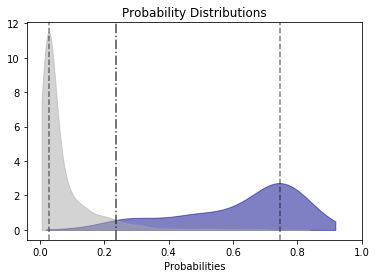


[[2898   43]
 [ 129  381]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2898   43  2941
1           129  381   510
All        3027  424  3451


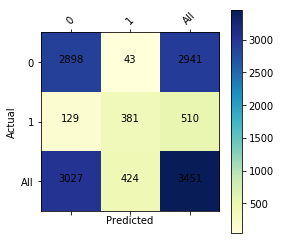

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2941
          1       0.90      0.75      0.82       510

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9501593740944654
-----------------

AUC_TRAIN =  0.9951415256026417

AUC =  0.9877251036376482


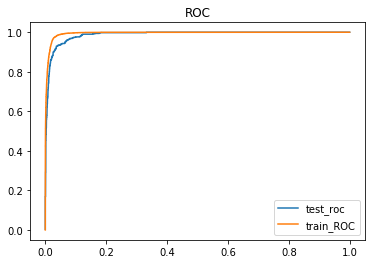

Probability density for train


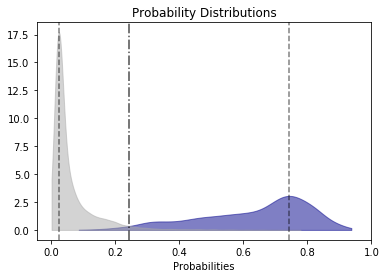

Probability density for test


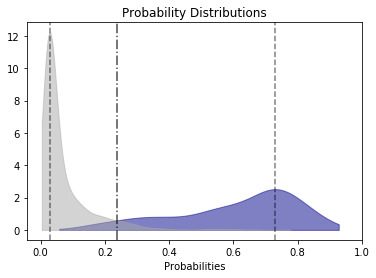


[[2910   32]
 [ 131  379]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2910   32  2942
1           131  379   510
All        3041  411  3452


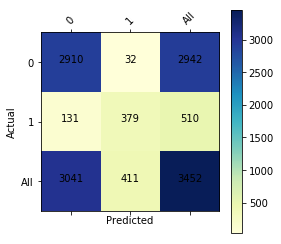

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2942
          1       0.92      0.74      0.82       510

avg / total       0.95      0.95      0.95      3452

ACCURACY 0.9527809965237544
-----------------

AUC_TRAIN =  0.9948337207363876

AUC =  0.9855950727871555


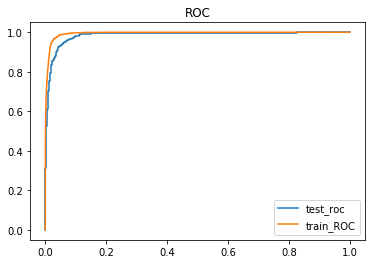

Probability density for train


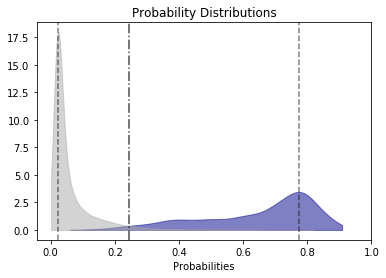

Probability density for test


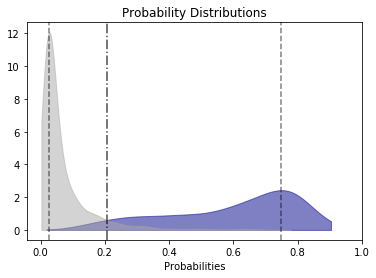


[[2912   31]
 [ 155  353]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2912   31  2943
1           155  353   508
All        3067  384  3451


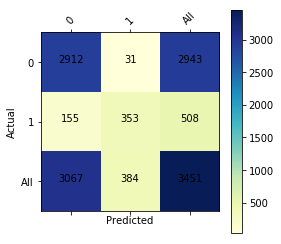

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2943
          1       0.92      0.69      0.79       508

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9461025789626195
-----------------

AUC_TRAIN =  0.9946251184558227

AUC =  0.9859997431513721


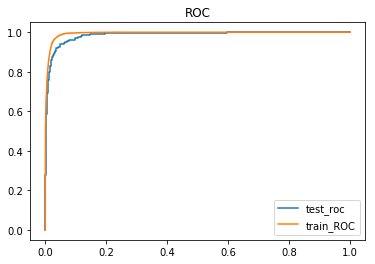

Probability density for train


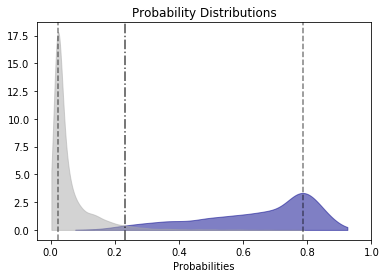

Probability density for test


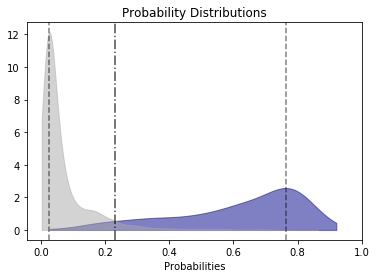


[[2915   28]
 [ 132  376]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2915   28  2943
1           132  376   508
All        3047  404  3451


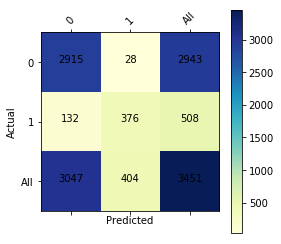

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2943
          1       0.93      0.74      0.82       508

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9536366270646189
-----------------

AUC_TRAIN =  0.9946312479678162

AUC =  0.9866189565456649


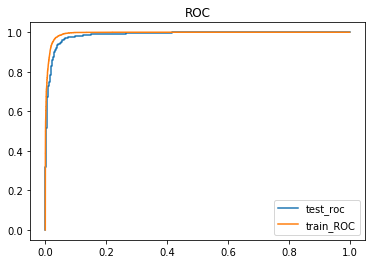

Probability density for train


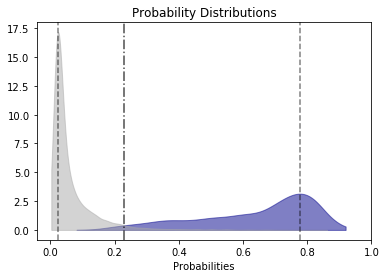

Probability density for test


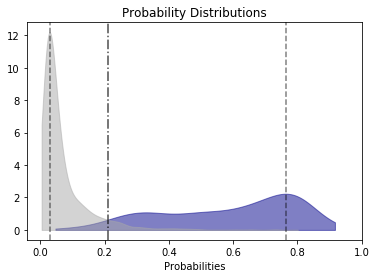


[[2928   20]
 [ 168  335]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2928   20  2948
1           168  335   503
All        3096  355  3451


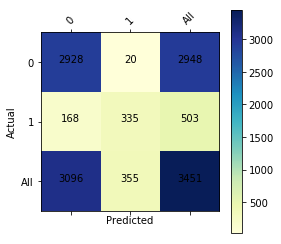

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2948
          1       0.94      0.67      0.78       503

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9455230368009273
-----------------

AUC_TRAIN =  0.9950663708902255

AUC =  0.989306669235153


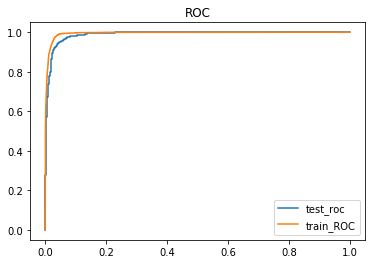

Probability density for train


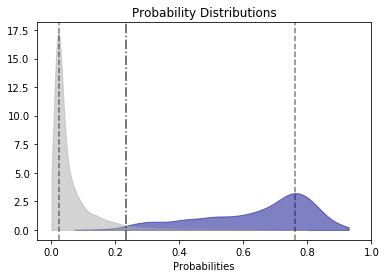

Probability density for test


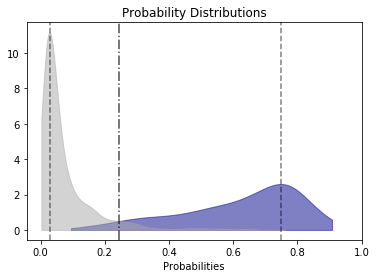


[[2906   37]
 [ 123  385]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2906   37  2943
1           123  385   508
All        3029  422  3451


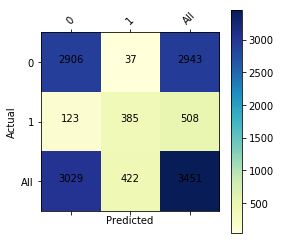

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2943
          1       0.91      0.76      0.83       508

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9536366270646189
-----------------

AUC_TRAIN =  0.9950111211606655

AUC =  0.987745395925683


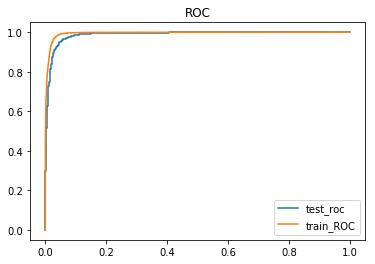

Probability density for train


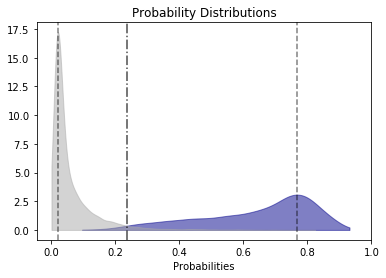

Probability density for test


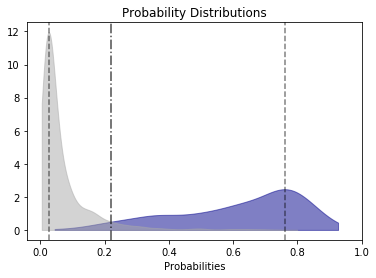


[[2909   33]
 [ 137  372]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2909   33  2942
1           137  372   509
All        3046  405  3451


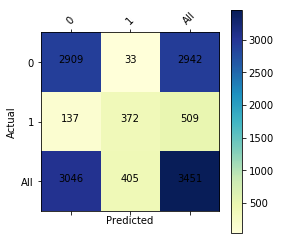

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2942
          1       0.92      0.73      0.81       509

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9507389162561576
-----------------

AUC_TRAIN =  0.9942525977863417

AUC =  0.9879244902418935


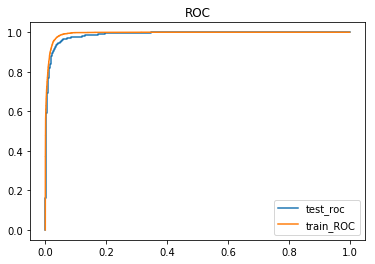

Probability density for train


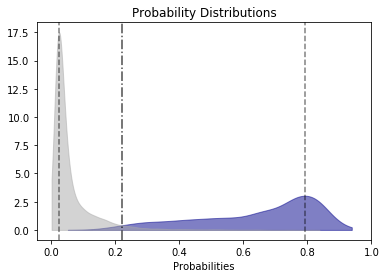

Probability density for test


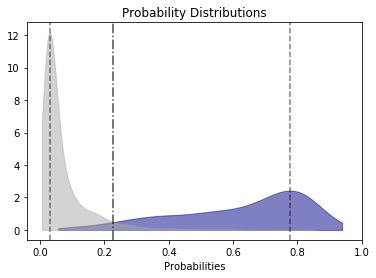


[[2919   26]
 [ 135  370]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2919   26  2945
1           135  370   505
All        3054  396  3450


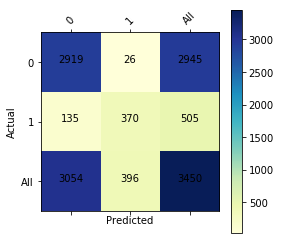

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2945
          1       0.93      0.73      0.82       505

avg / total       0.95      0.95      0.95      3450

ACCURACY 0.9533333333333334
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9949841441246139

AUC =  0.9824211502782932


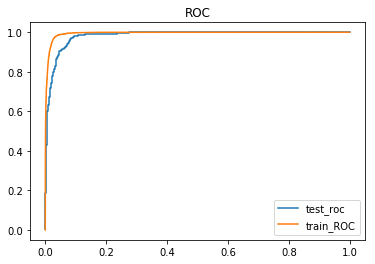

Probability density for train


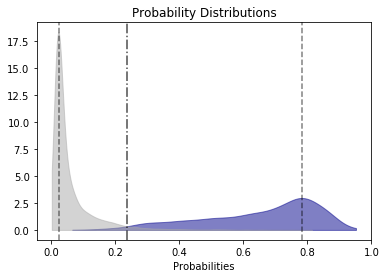

Probability density for test


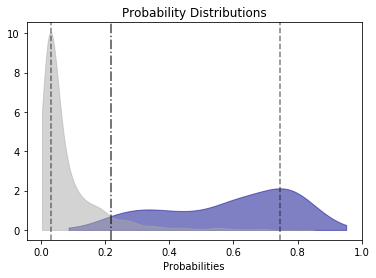


[[1932   28]
 [ 112  229]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1932   28  1960
1           112  229   341
All        2044  257  2301


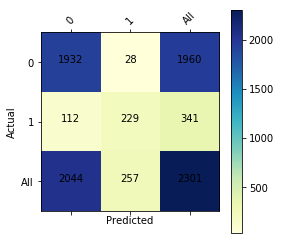

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.89      0.67      0.77       341

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.9391568883094307
-----------------

AUC_TRAIN =  0.9945030146442048

AUC =  0.987499605131931


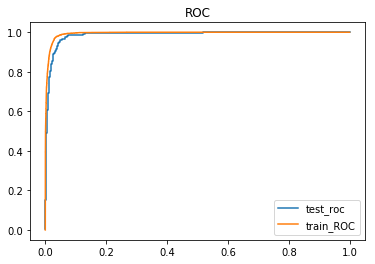

Probability density for train


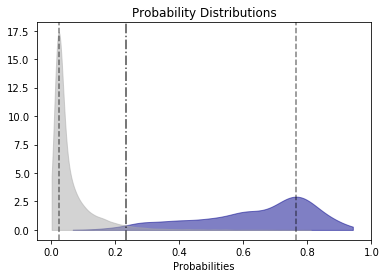

Probability density for test


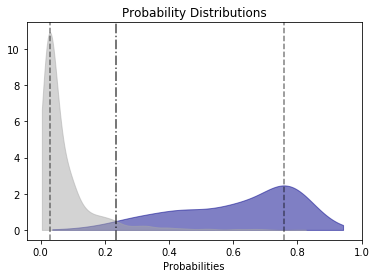


[[1938   23]
 [  95  244]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1938   23  1961
1            95  244   339
All        2033  267  2300


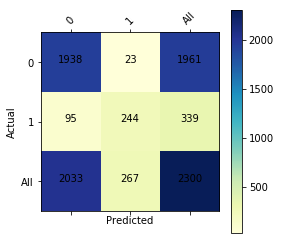

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1961
          1       0.91      0.72      0.81       339

avg / total       0.95      0.95      0.95      2300

ACCURACY 0.948695652173913
-----------------

AUC_TRAIN =  0.9946660796448827

AUC =  0.9872134625030973


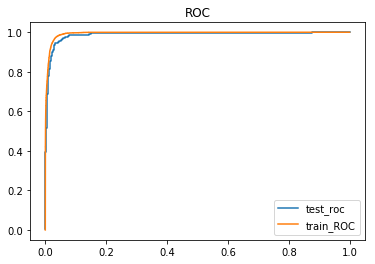

Probability density for train


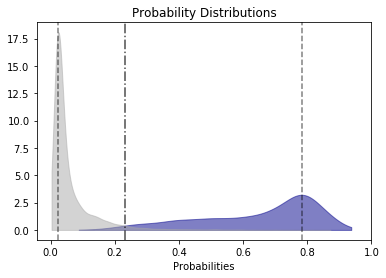

Probability density for test


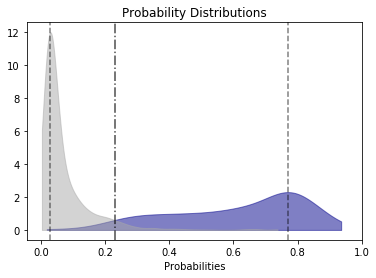


[[1949   15]
 [ 104  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1949   15  1964
1           104  233   337
All        2053  248  2301


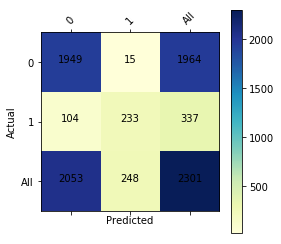

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1964
          1       0.94      0.69      0.80       337

avg / total       0.95      0.95      0.94      2301

ACCURACY 0.9482833550630161
-----------------

AUC_TRAIN =  0.9950165651480108

AUC =  0.9802162924473552


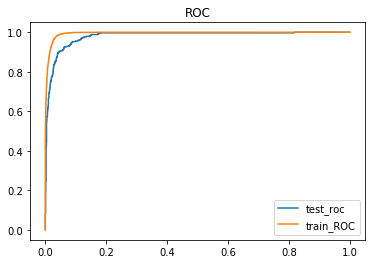

Probability density for train


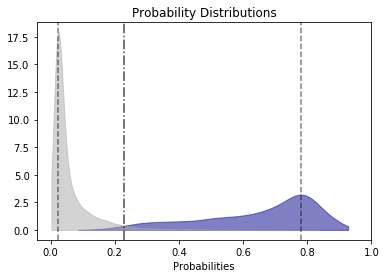

Probability density for test


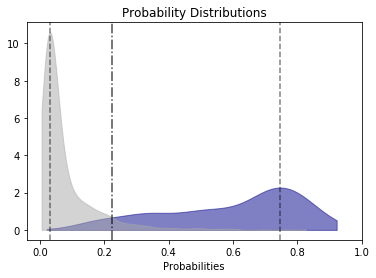


[[1939   23]
 [ 109  230]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1939   23  1962
1           109  230   339
All        2048  253  2301


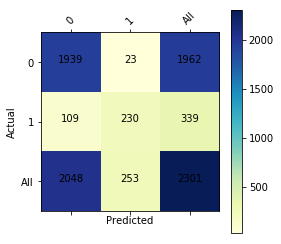

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.91      0.68      0.78       339

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.9426336375488917
-----------------

AUC_TRAIN =  0.994350661146669

AUC =  0.9861189400356295


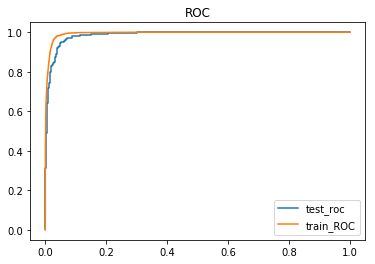

Probability density for train


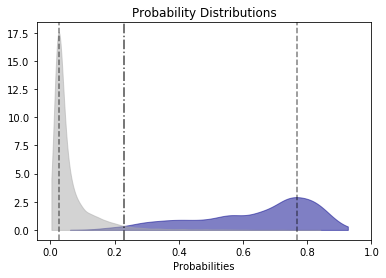

Probability density for test


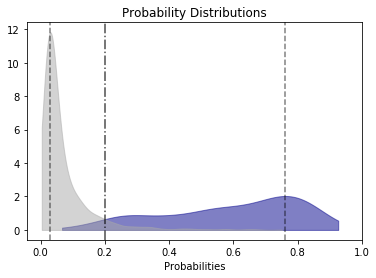


[[1944   19]
 [ 102  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   19  1963
1           102  236   338
All        2046  255  2301


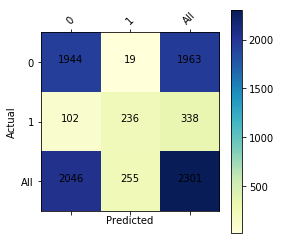

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1963
          1       0.93      0.70      0.80       338

avg / total       0.95      0.95      0.94      2301

ACCURACY 0.9474141677531508
-----------------

AUC_TRAIN =  0.9944438853047032

AUC =  0.9911280668917486


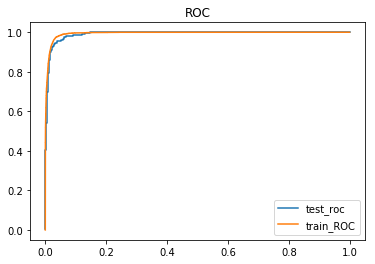

Probability density for train


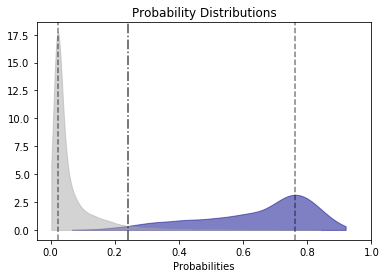

Probability density for test


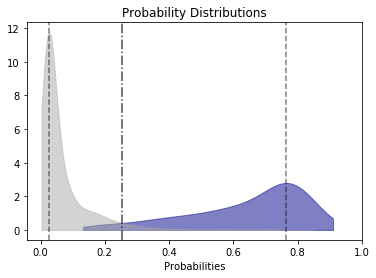


[[1939   20]
 [  72  270]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1939   20  1959
1            72  270   342
All        2011  290  2301


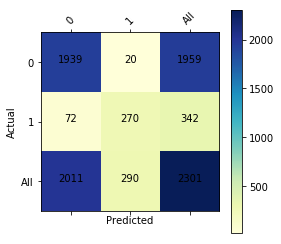

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1959
          1       0.93      0.79      0.85       342

avg / total       0.96      0.96      0.96      2301

ACCURACY 0.9600173837461973
-----------------

AUC_TRAIN =  0.9945025685799587

AUC =  0.985809284968983


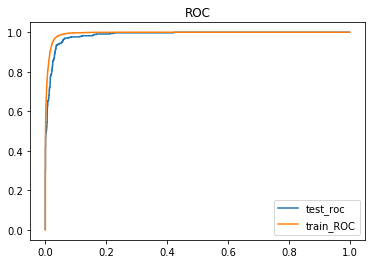

Probability density for train


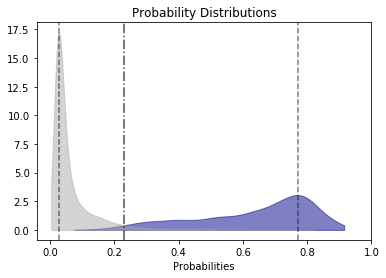

Probability density for test


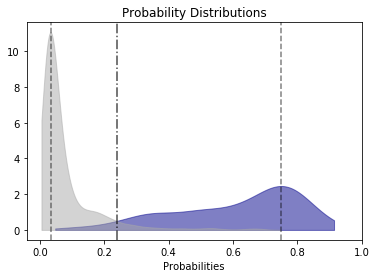


[[1935   27]
 [  96  243]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1935   27  1962
1            96  243   339
All        2031  270  2301


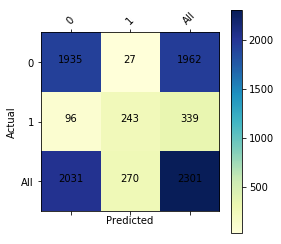

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.90      0.72      0.80       339

avg / total       0.94      0.95      0.94      2301

ACCURACY 0.9465449804432855
-----------------

AUC_TRAIN =  0.9943722785329469

AUC =  0.9866376645471653


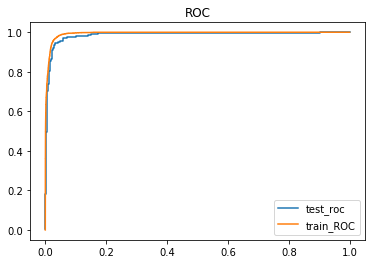

Probability density for train


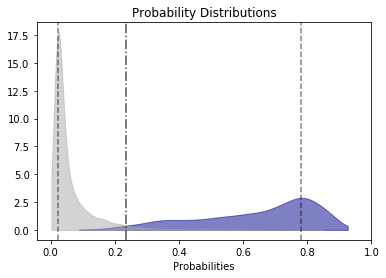

Probability density for test


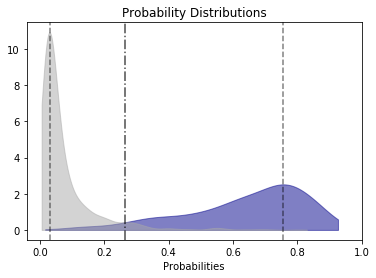


[[1934   27]
 [  72  267]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1934   27  1961
1            72  267   339
All        2006  294  2300


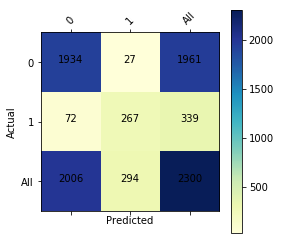

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1961
          1       0.91      0.79      0.84       339

avg / total       0.96      0.96      0.96      2300

ACCURACY 0.9569565217391305
-----------------

AUC_TRAIN =  0.9941709011870363

AUC =  0.9824821277111353


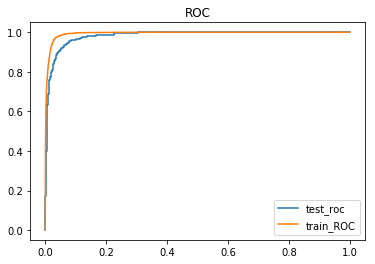

Probability density for train


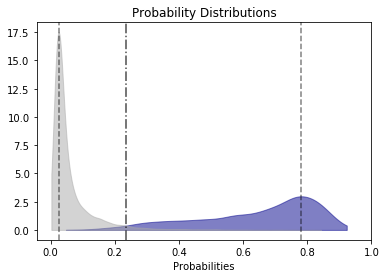

Probability density for test


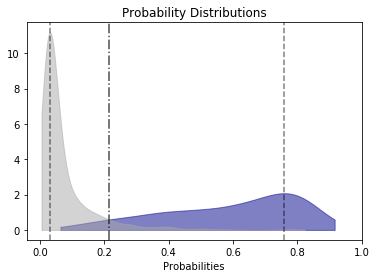


[[1946   19]
 [ 108  228]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1946   19  1965
1           108  228   336
All        2054  247  2301


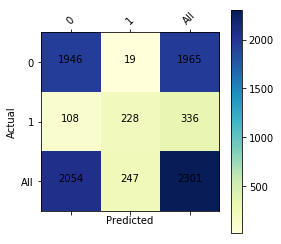

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1965
          1       0.92      0.68      0.78       336

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.944806605823555
-----------------

AUC_TRAIN =  0.9944125159715992

AUC =  0.9878771355870593


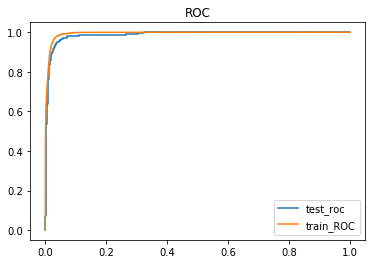

Probability density for train


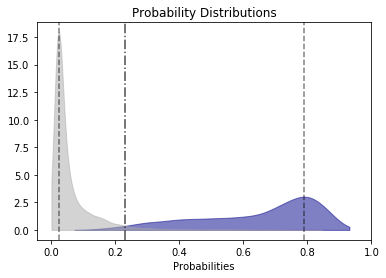

Probability density for test


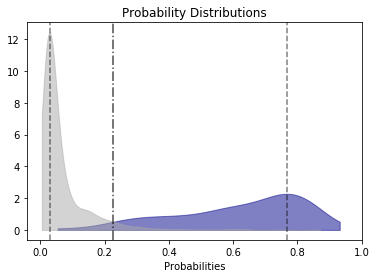


[[1947   18]
 [  90  246]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1947   18  1965
1            90  246   336
All        2037  264  2301


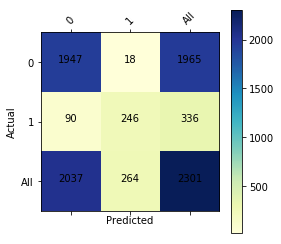

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1965
          1       0.93      0.73      0.82       336

avg / total       0.95      0.95      0.95      2301

ACCURACY 0.9530638852672751
-----------------

AUC_TRAIN =  0.9945419653731281

AUC =  0.9843148543920518


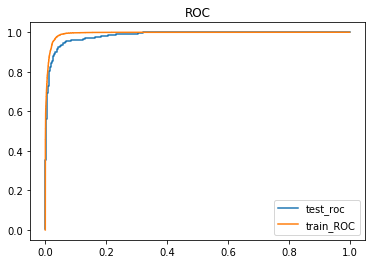

Probability density for train


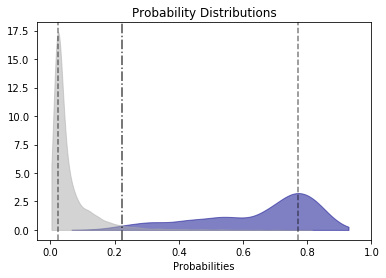

Probability density for test


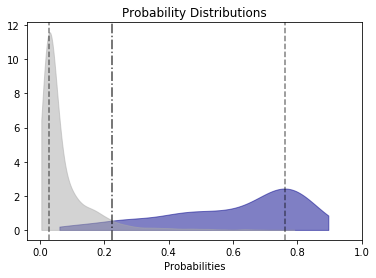


[[1947   16]
 [ 100  238]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1947   16  1963
1           100  238   338
All        2047  254  2301


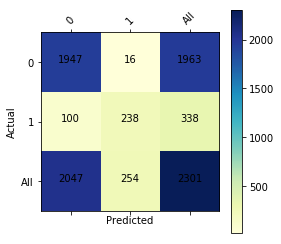

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1963
          1       0.94      0.70      0.80       338

avg / total       0.95      0.95      0.95      2301

ACCURACY 0.949587136027814
-----------------

AUC_TRAIN =  0.9944082872554019

AUC =  0.9858401065675565


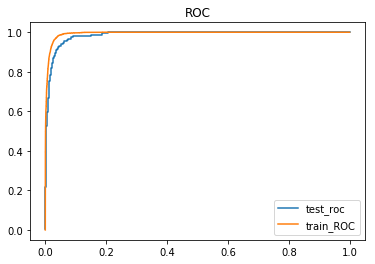

Probability density for train


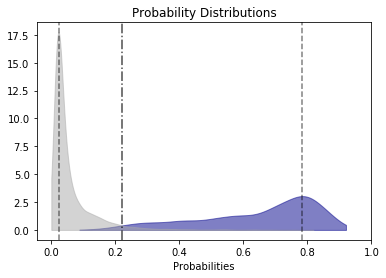

Probability density for test


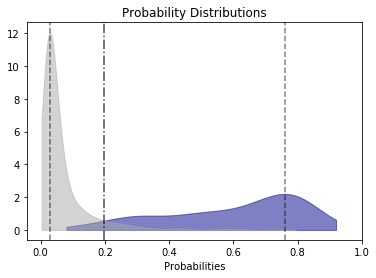


[[1941   21]
 [ 103  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   21  1962
1           103  236   339
All        2044  257  2301


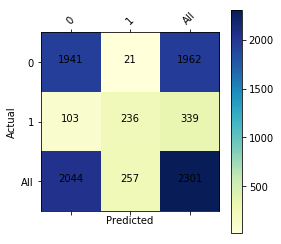

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.70      0.79       339

avg / total       0.94      0.95      0.94      2301

ACCURACY 0.9461103867883529
-----------------

AUC_TRAIN =  0.9946771736298776

AUC =  0.9901637262652846


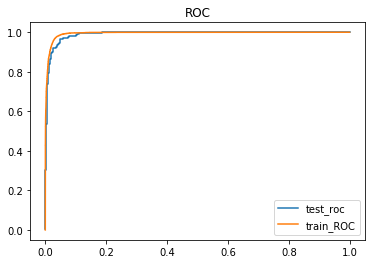

Probability density for train


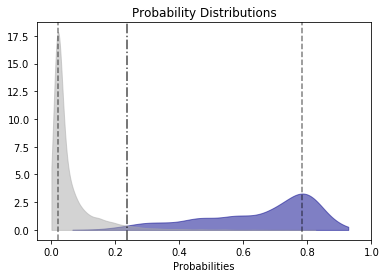

Probability density for test


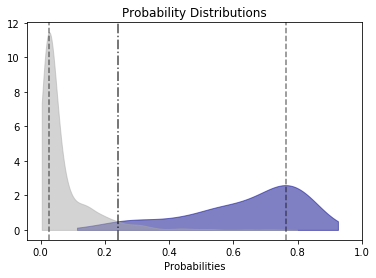


[[1944   19]
 [  72  265]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   19  1963
1            72  265   337
All        2016  284  2300


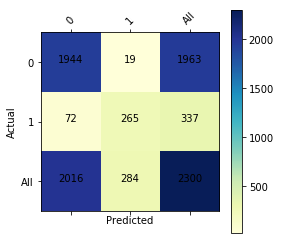

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1963
          1       0.93      0.79      0.85       337

avg / total       0.96      0.96      0.96      2300

ACCURACY 0.9604347826086956
-----------------

AUC_TRAIN =  0.9946999760360786

AUC =  0.9846113980215304


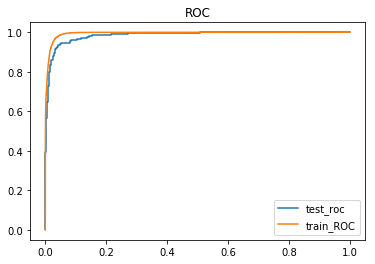

Probability density for train


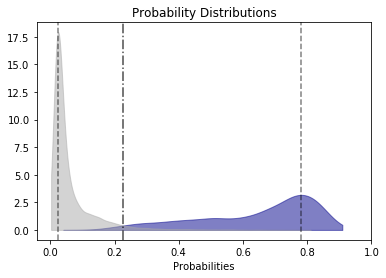

Probability density for test


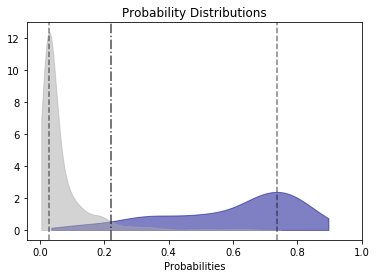


[[1945   19]
 [  99  237]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1945   19  1964
1            99  237   336
All        2044  256  2300


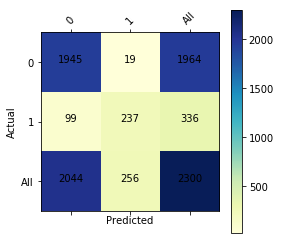

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1964
          1       0.93      0.71      0.80       336

avg / total       0.95      0.95      0.95      2300

ACCURACY 0.948695652173913
-----------------

AUC_TRAIN =  0.9944160850664215

AUC =  0.9844093998998729


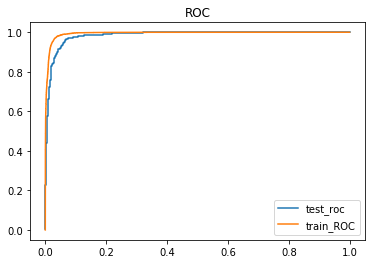

Probability density for train


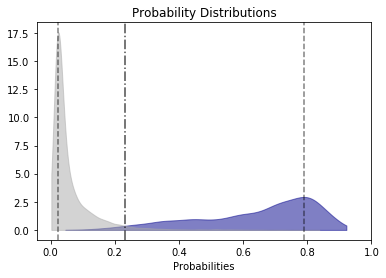

Probability density for test


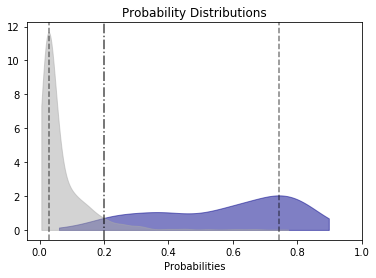


[[1942   20]
 [ 119  219]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1942   20  1962
1           119  219   338
All        2061  239  2300


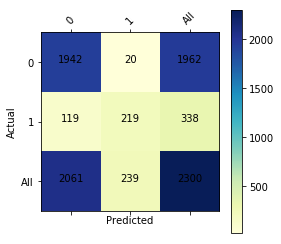

REPORT
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      1962
          1       0.92      0.65      0.76       338

avg / total       0.94      0.94      0.94      2300

ACCURACY 0.9395652173913044
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
